In [1]:
## All libraries required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import tensorflow as tf
%matplotlib inline

In [2]:
## Global Variables
image_path = "images/"
train_org  = pd.read_csv("training.csv")
test_org   = pd.read_csv("test.csv")

In [3]:
train_org.head()
## (x1,y1) is the lower left point and x2-x1 and y2-y1 are the width and height

,image_name,x1,x2,y1,y2
0,JPEG_20160706_121146_1000145715002.png,115,495,143,325
1,JPEG_20161119_174038_1000690577600.png,23,457,61,409
2,147444927651111470309333776-Roadster-Men-Casua...,37,601,13,470
3,147772332675720161028_161611.png,27,602,162,385
4,1473315333651DeeplearnS11638.png,60,586,174,325


In [4]:
test_org.head() ## doesn't have bounding box coordinates 

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,NaN,NaN,NaN,NaN
1,1473231475010DeeplearnS11276.png,NaN,NaN,NaN,NaN
2,JPEG_20161205_135307_1000155917326.png,NaN,NaN,NaN,NaN
3,JPEG_20160711_123440_1000518778437.png,NaN,NaN,NaN,NaN
4,JPEG_20160803_115329_100034020722.png,NaN,NaN,NaN,NaN


In [5]:
train_org.describe()
## Max x coordinate -> 640
## Min x coordinate -> -1
## Max y coordinate -> 480 (full width)
## Min y coordinate -> -1
## -1 means that full product extends beyond the boundaries of image of dimension (480,640)

,x1,x2,y1,y2
count,14000.000000,14000.000000,14000.000000,14000.000000
mean,115.970571,524.558571,88.897214,390.147000
std,73.800382,72.846189,56.172808,55.469778
min,-1.000000,145.000000,-1.000000,159.000000
25%,57.000000,470.000000,42.750000,346.000000
50%,105.000000,534.000000,86.000000,393.000000
75%,170.000000,582.000000,133.000000,435.000000
max,524.000000,640.000000,468.000000,480.000000


In [6]:
test_image_name = test_org["image_name"]
test_image_name.describe()

count                                12815
unique                               12815
top       1473661669975DeeplearnS11513.png
freq                                     1
Name: image_name, dtype: object

In [7]:
## Global
train_image_name = train_org["image_name"]
train_image_name.describe()

count                                     14000
unique                                    14000
top       JPEG_20161124_175116_100040544016.png
freq                                          1
Name: image_name, dtype: object

In [8]:
img_fetch = lambda img_name : plt.imread(image_path+img_name)

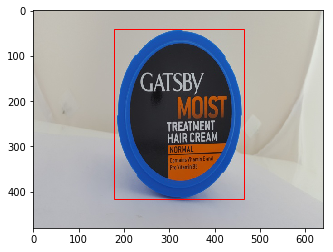

In [9]:
## Random example in train_org 
randn  = 13
coord  = train_org[train_org["image_name"]==train_image_name[randn]]
name   = train_image_name[randn]
x1,y1  = coord['x1'][randn],coord['y1'][randn]
x2,y2  = coord['x2'][randn],coord['y2'][randn]
coord  = coord.drop(['image_name'],axis=1)
coord  = coord.values[0]


def plot_img_bb(name,coord) :
    img    = img_fetch(name) ## numpy matrix of shape (width=480,length=640,3)
    fig,ax = plt.subplots()
    ax.imshow(img)
    rect = patches.Rectangle((coord[0],coord[2]),coord[1]-coord[0],coord[3]-coord[2],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

plot_img_bb(name,coord)

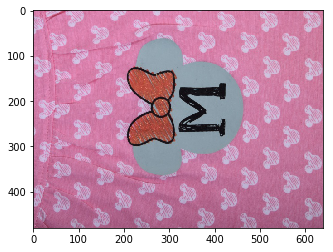

In [10]:
## Random example in test_org
randn  = 666
img    = img_fetch(test_image_name[randn]) ## numpy matrix of dim (width=480,length=640,3)
fig,ax = plt.subplots()
ax.imshow(img)

In [11]:
img[:,:,1].shape

(480, 640)

In [12]:
## Preparing training and testing set in train_org
def generate_train_test(seed=1) :
    np.random.seed(seed)

    train_coord = train_org.copy()
    train_coord = train_coord.drop(['image_name'],axis=1)
    train_coord = train_coord.values

    indices = np.random.permutation(train_coord.shape[0])
    split   = int(0.8 * train_coord.shape[0])
    train_idx, test_idx = indices[:split],indices[split:]

    X_train, X_test = train_image_name[train_idx].values, train_image_name[test_idx].values
    
    y_train, y_test = train_coord[train_idx,:], train_coord[test_idx,:]
    
    return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = generate_train_test(42)

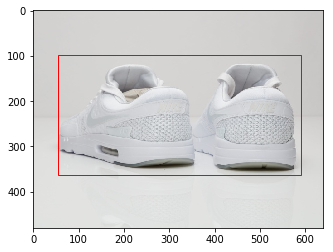

In [13]:
plot_img_bb(X_train[7777],y_train[7777])
## X_train, y_train are rightly index synchronized -- check any random value in range(0,11200)

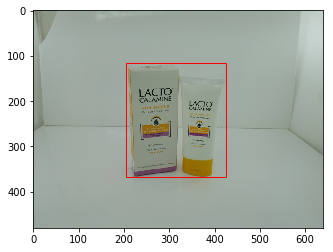

In [14]:
plot_img_bb(X_test[2345],y_test[2345])
## X_test, y_test are rightly index synchronized -- check any random value in range(0,2800)

In [15]:
## Preparing a function for cross validation set generator
def kfold_cv(X,y,k,seed=1) :
    np.random.seed(seed)
    idx   = np.random.permutation(X.shape[0])
    folds = np.array_split(idx,k)

    cv_sets = {}
    
    for i in range(len(folds)) :
        cv_sets["fold"+str(i)] = {"train":0,"test":0}
        temp_X = np.array(['dummy'],dtype='object')  ## For append and concatenate to work
        temp_y = np.array([[0,0,0,0]],dtype='int')   ## For append and concatenate to work
        for j in range(len(folds)) :
            if j == i :
                cv_sets["fold"+str(j)]["test"] = {"X":X[folds[j]],"y":y[folds[j]]}
            else :
                temp_X = np.concatenate((temp_X,X[folds[j]]))
                temp_y = np.append(temp_y,y[folds[j]],axis=0)
        temp_X,temp_y = temp_X[1:],temp_y[1:]   ## removing dummy index
        idx = np.random.permutation(len(temp_X))
        temp_X, temp_y  = temp_X[idx], temp_y[idx]
        cv_sets["fold"+str(i)]["train"] = {"X":temp_X,"y":temp_y}
    
    return cv_sets

folds = kfold_cv(X_train,y_train,5,33)

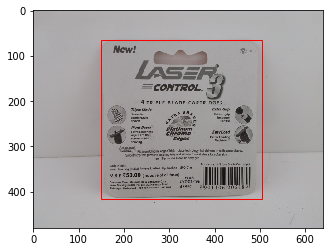

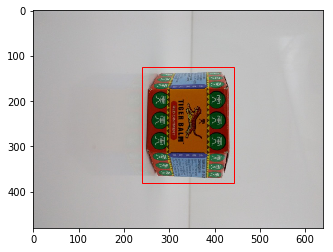

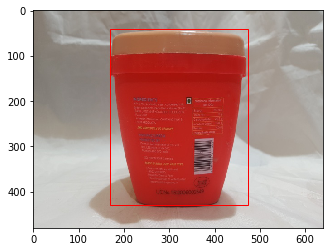

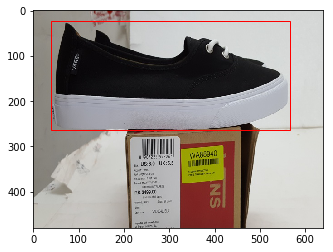

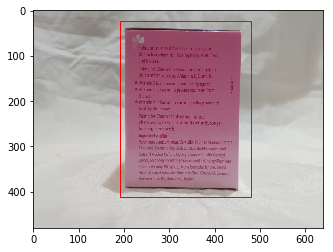

In [16]:
plot_img_bb(folds["fold4"]["train"]["X"][666],folds["fold4"]["train"]["y"][666])
plot_img_bb(folds["fold3"]["train"]["X"][666],folds["fold3"]["train"]["y"][666])
plot_img_bb(folds["fold2"]["train"]["X"][666],folds["fold2"]["train"]["y"][666])
plot_img_bb(folds["fold1"]["train"]["X"][666],folds["fold1"]["train"]["y"][666])
plot_img_bb(folds["fold0"]["train"]["X"][666],folds["fold0"]["train"]["y"][666])
## all folds rightly index synchronized -- check any random value in range(0,8960)

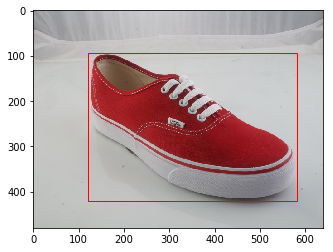

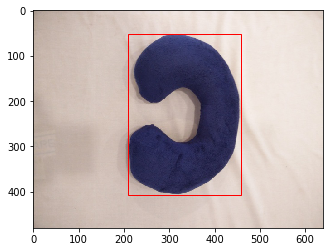

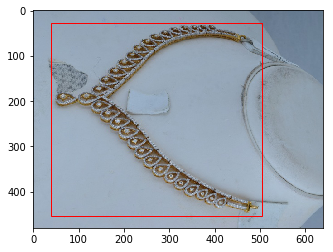

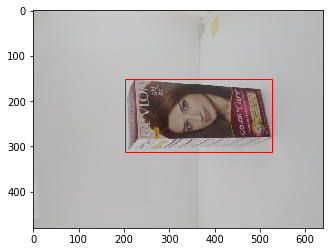

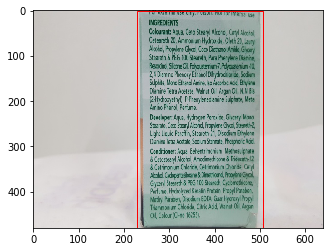

In [18]:
plot_img_bb(folds["fold4"]["test"]["X"][666],folds["fold4"]["test"]["y"][666])
plot_img_bb(folds["fold3"]["test"]["X"][666],folds["fold3"]["test"]["y"][666])
plot_img_bb(folds["fold2"]["test"]["X"][666],folds["fold2"]["test"]["y"][666])
plot_img_bb(folds["fold1"]["test"]["X"][666],folds["fold1"]["test"]["y"][666])
plot_img_bb(folds["fold0"]["test"]["X"][666],folds["fold0"]["test"]["y"][666])
## all folds rightly index synchronized -- check any random value in range(0,2240)

In [17]:
## get image_matrix for a minibatch
def get_mini_batch_image_matrix(batch_size,X_names) :
        X = np.zeros((batch_size,480,640,3))
        for i in range(len(X_names)):
            X[i,:,:,:] = image_fetch(X_names[i])
        return X

In [ ]:
## Preparing a simple deep CNN architecture which will capture all the features of images
## and predict the bb coordinates

